# Steam videogames platform project

In this project, we conduct a study of Steam's game marketplace to understand the videogames market, and determine the most influencial factors for games popularity. We are provided a dataset containing information about the videogames available on Steam platform: names, description, developer, release date, number of owners, ratings, etc. The data corresponds to what is accessible to a customer of the platform. In the perspective of a real market analysis, it is nevertheless missing important information such as the production costs and duration, production means (eg use of generative AI), more precise info on the game mechanics, geographical/age distribution of players, etc.

For our analysis, we will follow the guidelines proposed in the project description.

Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Macro-level analysis](#macro)
3. [Genres analysis](#genres)
4. [Platform analysis](#macro)
5. [Conclusion and perspectives](#conclusion)


We will highlight both the use of Spark SQL API and SQL-like statements for the data analysis in this project. Spark API will be used for data preprocessing and the preparation of relevant dataframes. SQL-like statements will be used subsequently to carry data analysis proper.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

sc = SparkContext(appName="steam-videogames-platform-analysis")
spark = SparkSession.builder.appName('steam-videogames-platform-analysis') \
                            .getOrCreate()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## <a name="loading"></a> Data loading and preprocessing

The dataset can be found in a public S3 bucket. If direct data loading from S3 URL is not possible, the following code uses `boto3` to download the file, then converts the resulting string to RDD before reading.
```python
import boto3
from botocore import UNSIGNED
from botocore.client import Config

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
obj = s3.get_object(Bucket='full-stack-bigdata-datasets',
                    Key='Big_Data/Project_Steam/steam_game_output.json')
data = obj['Body'].read().decode('utf-8')

# convert to rdd before reading
rddjson = sc.parallelize([data])
raw_df = spark.read.json(rddjson)
```

An alternative way is to download the dataset on the local file system from
[https://full-stack-bigdata-datasets.s3.amazonaws.com/Big_Data/Project_Steam/steam_game_output.json](https://full-stack-bigdata-datasets.s3.amazonaws.com/Big_Data/Project_Steam/steam_game_output.json).

In [2]:
## direct download from S3
# raw_df = spark.read.json('s3a://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json')

## from local filesystem
raw_df = spark.read.json('./steam_game_output.json')

raw_df.printSchema(2)

root
 |-- data: struct (nullable = true)
 |    |-- appid: long (nullable = true)
 |    |-- categories: array (nullable = true)
 |    |-- ccu: long (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- discount: string (nullable = true)
 |    |-- genre: string (nullable = true)
 |    |-- header_image: string (nullable = true)
 |    |-- initialprice: string (nullable = true)
 |    |-- languages: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- negative: long (nullable = true)
 |    |-- owners: string (nullable = true)
 |    |-- platforms: struct (nullable = true)
 |    |-- positive: long (nullable = true)
 |    |-- price: string (nullable = true)
 |    |-- publisher: string (nullable = true)
 |    |-- release_date: string (nullable = true)
 |    |-- required_age: string (nullable = true)
 |    |-- short_description: string (nullable = true)
 |    |-- tags: struct (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- website: s

### Column parsing and preprocessing

In [3]:
## parse release date
def to_date_(col, formats=('yyyy/MM/d', 'yyyy/MM')):
    return F.coalesce(*[F.to_date(col, f) for f in formats])

raw_df = raw_df.withColumn(
    'data',
    raw_df['data'].withField('release_date', to_date_(raw_df['data.release_date']))
)

This code is unnecessarily complex: we modify a field inside the struct column `'data'` of the dataset. This column basically contains all the data, including the a replica of the other column `'id'`. To make things simpler, we extract the `'data'` column, for easier access to the different fields.

In [4]:
## extract the 'data' fields as a dataframe
df = raw_df.select('data.*').alias('*')
df.printSchema(2)

root
 |-- appid: long (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ccu: long (nullable = true)
 |-- developer: string (nullable = true)
 |-- discount: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- header_image: string (nullable = true)
 |-- initialprice: string (nullable = true)
 |-- languages: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negative: long (nullable = true)
 |-- owners: string (nullable = true)
 |-- platforms: struct (nullable = true)
 |    |-- linux: boolean (nullable = true)
 |    |-- mac: boolean (nullable = true)
 |    |-- windows: boolean (nullable = true)
 |-- positive: long (nullable = true)
 |-- price: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- required_age: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- tags: struct (nullable = true)
 |    |-- 1980s: long 

In [5]:
## convert price to $
df = df.withColumn('price', df['price'].cast('float') / 100) \
       .withColumn('initialprice', df['initialprice'].cast('float') / 100)

## parse required_age as int
df = df.withColumn(
    'required_age',
    F.regexp_extract(df['required_age'], r'\d+', 0).cast('Integer')
)
df.select('required_age').show(5) # most games have no age requirement

+------------+
|required_age|
+------------+
|           0|
|           0|
|           0|
|           0|
|           0|
+------------+
only showing top 5 rows



The owner ranges are specified on a logarithmic scale (each successive range increases in size by a factor $\sim 2$). In order to preserve such scaling, we estimate the number of owners from the two bounds by taking their *geometric* mean. This is problematic for the lowest range (0 - 20000), which we estimate by $\sqrt{20000} \simeq 141$. We must keep in mind that this last value probably underestimates the actual number of owners.

In [6]:
owners_low = F.regexp_replace(F.split(df['owners'], ' .. ')[0], ',', '').cast('Double')
owners_high = F.regexp_replace(F.split(df['owners'], ' .. ')[1], ',', '').cast('Double')
owners_est = F.sqrt(F.when(owners_low==0, 1).otherwise(owners_low) * owners_high)
df = df.withColumn('owners_low', owners_low) \
       .withColumn('owners_high', owners_high) \
       .withColumn('owners_est', owners_est)
df.select('owners_low', 'owners_high', 'owners_est').show()

+----------+-----------+-------------------+
|owners_low|owners_high|         owners_est|
+----------+-----------+-------------------+
|     1.0E7|      2.0E7|1.414213562373095E7|
|       0.0|    20000.0|  141.4213562373095|
|  200000.0|   500000.0|  316227.7660168379|
|  100000.0|   200000.0| 141421.35623730952|
|       0.0|    20000.0|  141.4213562373095|
|  100000.0|   200000.0| 141421.35623730952|
|       0.0|    20000.0|  141.4213562373095|
|   20000.0|    50000.0| 31622.776601683792|
|       0.0|    20000.0|  141.4213562373095|
|       0.0|    20000.0|  141.4213562373095|
|       0.0|    20000.0|  141.4213562373095|
|  200000.0|   500000.0|  316227.7660168379|
|       0.0|    20000.0|  141.4213562373095|
|  100000.0|   200000.0| 141421.35623730952|
|   20000.0|    50000.0| 31622.776601683792|
|   20000.0|    50000.0| 31622.776601683792|
|       0.0|    20000.0|  141.4213562373095|
|  100000.0|   200000.0| 141421.35623730952|
|   20000.0|    50000.0| 31622.776601683792|
|   20000.

### Construction of intermediate dataframes

In [7]:
## main dataframe
main_cols = [
    'appid', 'name', 'developer', 'publisher', 'genre', 'type',
    'positive', 'negative', 'price', 'initialprice', 'discount', 'ccu',
    'release_date', 'required_age', 'owners_low', 'owners_high', 'owners_est'
]
main_df = df.select(*main_cols)

main_df.show(10)

+-------+------------------------------------+--------------------+--------------------+--------------------+----+--------+--------+-----+------------+--------+-----+------------+------------+----------+-----------+-------------------+
|  appid|                                name|           developer|           publisher|               genre|type|positive|negative|price|initialprice|discount|  ccu|release_date|required_age|owners_low|owners_high|         owners_est|
+-------+------------------------------------+--------------------+--------------------+--------------------+----+--------+--------+-----+------------+--------+-----+------------+------------+----------+-----------+-------------------+
|     10|                      Counter-Strike|               Valve|               Valve|              Action|game|  201215|    5199| 9.99|        9.99|       0|13990|  2000-11-01|           0|     1.0E7|      2.0E7|1.414213562373095E7|
|1000000|                           ASCENXION|IndigoBlue

In [8]:
## release dates dataframe
release_dates_df = df.select('appid', 'release_date')

release_dates_df.show(10)

+-------+------------+
|  appid|release_date|
+-------+------------+
|     10|  2000-11-01|
|1000000|  2021-05-14|
|1000010|  2020-10-16|
|1000030|  2020-10-14|
|1000040|  2019-03-30|
|1000080|  2019-06-24|
|1000100|  2019-01-24|
|1000110|  2019-04-08|
|1000130|  2019-01-06|
|1000280|  2021-09-09|
+-------+------------+
only showing top 10 rows



In [9]:
## tags dataframe
tags_df = df.select('appid', 'tags.*') \
            .alias('*') \
            .fillna(0)

tags_df.show(10)

+-------+-----+------+----+---+----------+-------------+---------+---+----------+-------------+---------+--------------+---+----+-----------+---+--------+------+----------+----------+----------------+----------------+---------+---------+-----------+------+-----------------+-------+-------+--------------------+-----+------+-------+-------------+-----------------------+--------+-------------+------------------------+-----------+----------------+------------+----------+--------------+---+-------------+--------+----------------+----------+-------------+-----------+---------+---------+-----+-----+----------+---------+-------+------+--------+-----------+-----------+----+----------+------------+---------+-------+--------+------+----+---------------------+-----------------------+-----+--------------+-------------------------+---------+------------+-----------+-------+-------+-----+--------------+------+--------+------------+----------+--------+------+-------------+------+----------+-----------

In [10]:
## videogames genre dataaframe
genres = df.select('appid', F.explode(F.split(df['genre'], ', ')).alias('genre'))

genres_df = genres.groupby('appid') \
                  .pivot('genre') \
                  .count()
genres_df = genres_df.select(
    'appid',
    *[F.when(F.col(c).isNull(), 0).otherwise(1).alias(c)
      for c in genres_df.columns if c != 'appid']
)

genres_df.show(10)

+-------+-----+----------+------+---------+--------------------+----------------+------+---------------------+------------+---------+------------+----------------+-----+-----+---------------------+-----+------+-------------+-----+------+--------------+----------+-----------------+------+--------+---------+----------------+-------+--------------+
|  appid|     |Accounting|Action|Adventure|Animation & Modeling|Audio Production|Casual|Design & Illustration|Early Access|Education|Free to Play|Game Development| Gore|Indie|Massively Multiplayer|Movie|Nudity|Photo Editing|  RPG|Racing|Sexual Content|Simulation|Software Training|Sports|Strategy|Utilities|Video Production|Violent|Web Publishing|
+-------+-----+----------+------+---------+--------------------+----------------+------+---------------------+------------+---------+------------+----------------+-----+-----+---------------------+-----+------+-------------+-----+------+--------------+----------+-----------------+------+--------+-------

Another less idiomatic approach would be:
```python
genres = raw_df.select(
    F.col('data.appid').alias('appid'),
    F.split(raw_df['data.genre'], ', ').alias('genre')
)
all_genres = genres.select(F.explode(genres['genre']).alias('genre')).distinct()
for x in all_genres.collect():
    genres = genres.withColumn(x[0], F.array_contains(genres['genre'], x[0]))

genres_df = genres.select('appid', *[x[0] for x in all_genres.collect()])
```

In [11]:
## videogames categories dataframe
categories = df.select('appid', F.explode(df['categories']).alias('category'))

categories_df = categories.groupby('appid') \
                          .pivot('category') \
                          .count()
categories_df = categories_df.select(
    'appid',
    *[F.when(F.col(c).isNull(), False).otherwise(True).alias(c)
      for c in categories_df.columns if c != 'appid']
)

categories_df.show(10)

+-------+------------------+-----+--------------------+--------------------------+-----------------------+----------------+-------------------+---------------------+---------+-------+-----+-----+------------------+------------+------------+----------+--------------------------+-----+--------------------+--------------------+-----------------+---------------------+-------------------+-------------------------+-----------------------+-------------+-----+------------------+-----------+------------------+-------------------+------------------------+--------------+--------------------+----------+------------------------+
|  appid|Captions available|Co-op|Commentary available|Cross-Platform Multiplayer|Full controller support|In-App Purchases|Includes Source SDK|Includes level editor|LAN Co-op|LAN PvP|  MMO| Mods|Mods (require HL2)|Multi-player|Online Co-op|Online PvP|Partial Controller Support|  PvP|Remote Play Together|Remote Play on Phone|Remote Play on TV|Remote Play on Tablet|Shared/Spl

In [12]:
## videogames platforms dataframe
platforms_df = df.select('appid', 'platforms.*') \
                 .alias('*')

platforms_df.show(10)

+-------+-----+-----+-------+
|  appid|linux|  mac|windows|
+-------+-----+-----+-------+
|     10| true| true|   true|
|1000000|false|false|   true|
|1000010|false|false|   true|
|1000030|false| true|   true|
|1000040|false|false|   true|
|1000080|false| true|   true|
|1000100|false|false|   true|
|1000110|false|false|   true|
|1000130|false| true|   true|
|1000280|false|false|   true|
+-------+-----+-----+-------+
only showing top 10 rows



In [13]:
## videogames languages dataframe
search = [r'\[b\]\*\[/b\]', '\r\n', ';', ', +']
replace = ['', ',', ',', ',']
languages = df['languages']
for s, r in zip(search, replace):
    languages = F.regexp_replace(languages, s, r).alias('language')
languages = F.explode(F.split(languages, ',')).alias('language')

languages_df = df.select('appid', languages) \
                 .groupby('appid') \
                 .pivot('language') \
                 .count()

languages_df = languages_df.select(
    'appid',
    *[F.when(F.col(c).isNull(), 0).otherwise(1).alias(c)
      for c in languages_df.columns if c not in {'', 'appid'}],
)
languages_df = languages_df.withColumn(
    'total',
    sum([F.col(c) for c in languages_df.columns if c not in {'', 'appid'}])
)

languages_df.show(10)

+-------+---------------+-----------------------------+---------+--------+------+-----------+------+------+----------+-------+---------+-------+--------+-----+------+-----+-----+-------+--------------------+----------------------+--------+--------+-------+------+--------+--------+------+-----+------+-----+---------+---------+----------+-----+-------+--------+--------+---------+-------+------+------+-------+----------+-------------+----------+-----+-----+-------+---------+---------+-------------+-------+------+----------+-------------------+---------------------+------------------+--------+-------+-------+------------------+------+---------+-----------------------+---------------+-------+-------+-----+------+-----+-------------------+-------------------------------+-------+---------+-----+-----+---------+----------+-----+
|  appid|#lang_slovakian|(all with full audio support)|Afrikaans|Albanian|Arabic|Azerbaijani|Bangla|Basque|Belarusian|Bosnian|Bulgarian|Catalan|Croatian|Czech|Danish| 

### Creation of temporary views for SQL querying

In [14]:
main_df.createOrReplaceTempView('main')
tags_df.createOrReplaceTempView('tags')
genres_df.createOrReplaceTempView('genres')
release_dates_df.createOrReplaceTempView('release_dates')
categories_df.createOrReplaceTempView('categories')
platforms_df.createOrReplaceTempView('platforms')
languages_df.createOrReplaceTempView('languages')

## <a name="macro"></a> Macro-level analysis

We begin our study by analyzing the market globally. We will focus on the following:
- Games popularity and revenues
- Publishers and developers popularity and revenues
- Evolution of the market in terms of game releases
- Games public and availability


### Games popularity and revenues

There are interesting patterns in game usage, price and revenues which we highlight here.

In [15]:
## dataframe to study owners and revenues
df = spark.sql(
    """
    SELECT
      name,
      owners_low,
      owners_est,
      price,
      price * owners_low AS revenues_low,
      price * owners_est AS revenues_est
    FROM
      main
    """
)
df.createOrReplaceTempView('df')
df.describe().show() # no direct SQL query for that

## with databricks
# display(df)

+-------+------------------------+-----------------+--------------------+------------------+--------------------+--------------------+
|summary|                    name|       owners_low|          owners_est|             price|        revenues_low|        revenues_est|
+-------+------------------------+-----------------+--------------------+------------------+--------------------+--------------------+
|  count|                   55691|            55691|               55691|             55691|               55691|               55691|
|   mean|                Infinity|78868.21928139197|  117232.52959757973| 7.732849832104521|  1000222.2621249394|  1481758.2943004507|
| stddev|                     NaN|1095229.232005134|  1686752.1867264835|10.931345827234507|1.2181509657020958E7|1.8184603510661047E7|
|    min|          Fieldrunners 2|              0.0|   141.4213562373095|               0.0|                 0.0|                 0.0|
|    max|～Daydream～蝶が舞う頃に|            2.0E8|3.162277660

The basic statistics shown here reveal interesting characteristics of the game market.
- The average game price is below 10$. Actually, 7780 games are free. Such games actually generate a major part of their revenue from in-game microtransactions. This is an important aspect of the video game industry that we will not be able to analyze here.
- Concerning game owners and revenues, the mean and the median differ by 3 orgers of magnitude. The market is thus extremely inhomogeneous.

In [16]:
spark.sql("SELECT * FROM df ORDER BY owners_est DESC").show()

+--------------------+----------+--------------------+-----+-------------------+--------------------+
|                name|owners_low|          owners_est|price|       revenues_low|        revenues_est|
+--------------------+----------+--------------------+-----+-------------------+--------------------+
|              Dota 2|     2.0E8|3.1622776601683795E8|  0.0|                0.0|                 0.0|
|           New World|     5.0E7| 7.071067811865476E7|19.99|9.994999999999999E8|1.4135064555919085E9|
|     Team Fortress 2|     5.0E7| 7.071067811865476E7|  0.0|                0.0|                 0.0|
| PUBG: BATTLEGROUNDS|     5.0E7| 7.071067811865476E7|  0.0|                0.0|                 0.0|
|Counter-Strike: G...|     5.0E7| 7.071067811865476E7|  0.0|                0.0|                 0.0|
|            Unturned|     2.0E7| 3.162277660168379E7|  0.0|                0.0|                 0.0|
|           Destiny 2|     2.0E7| 3.162277660168379E7|  0.0|                0.0|  

In [17]:
spark.sql("SELECT * FROM df ORDER BY revenues_est DESC").show()

+--------------------+----------+-------------------+-----+--------------------+--------------------+
|                name|owners_low|         owners_est|price|        revenues_low|        revenues_est|
+--------------------+----------+-------------------+-----+--------------------+--------------------+
|          ELDEN RING|     2.0E7|3.162277660168379E7|59.99|            1.1998E9|1.8970503683350108E9|
|           New World|     5.0E7|7.071067811865476E7|19.99| 9.994999999999999E8|1.4135064555919085E9|
|                Rust|     2.0E7|3.162277660168379E7|39.99|             7.998E8|1.2645948363013349E9|
|  Grand Theft Auto V|     2.0E7|3.162277660168379E7|29.98|             5.996E8| 9.480508425184801E8|
|      Cyberpunk 2077|     1.0E7|1.414213562373095E7|59.99|             5.999E8| 8.483867160676197E8|
|            HITMAN 2| 5000000.0|  7071067.811865475|99.99|            4.9995E8| 7.070360705084288E8|
|Tom Clancy's Rain...|     2.0E7|3.162277660168379E7|19.99|3.9979999999999994E8|  

Among the most popular games, we recognize well known games and franchises (Elden Ring, Grand Theft Auto, The Witcher, etc). We also note that among them, more than half are free to play. This shows that microtransactions are an important part of games revenues from Steam's platform. We will not be able to analyze this source of revenues with this dataset.

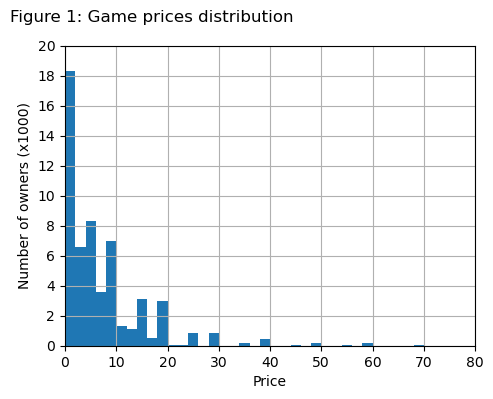

In [18]:
prices = spark.sql("SELECT price FROM df").toPandas()

fig1, ax1 = plt.subplots(
    nrows=1, ncols=1, figsize=(5, 4), dpi=100,
    gridspec_kw={'left': 0.13, 'right': 0.95, 'top': 0.89, 'bottom': 0.14})
fig1.suptitle('Figure 1: Game prices distribution', x=0.02, ha='left')

ax1.hist(prices, bins=np.linspace(0, 100, 51))
ax1.set_xlim(0, 80)
ax1.set_ylim(0, 20000)
ax1.set_yticks(np.linspace(0, 20000, 11), np.arange(0, 21, 2))
ax1.grid(visible=True)
ax1.set_xlabel('Price ($)')
ax1.set_ylabel('Number of owners (x1000)')

plt.show()

Figure 1 shows the distribution of prices. We recover the fact that game prices are low in general. We note that prices have preferential values: 4.99, 9.99, 14.99, etc.

In [19]:
## Cumulative game owners distribution function
owners_distrib = spark.sql(
    """
    SELECT 
      owners_low, 
      count, 
      SUM (count) OVER (
        ORDER BY 
          owners_low DESC
      ) as compl_cdf
    FROM 
      (
        SELECT 
          owners_low, 
          COUNT (owners_low) / (
            SELECT 
              COUNT (owners_low) 
            FROM 
              df
          ) AS count 
        FROM 
          df 
        GROUP BY 
          owners_low
      ) 
    ORDER BY 
      owners_low
    """
)
owners_distrib.show()

+----------+--------------------+--------------------+
|owners_low|               count|           compl_cdf|
+----------+--------------------+--------------------+
|       0.0|  0.6836293117379828|                 1.0|
|   20000.0| 0.13081108258066834|  0.3163706882620172|
|   50000.0| 0.06634824298360596| 0.18555960568134888|
|  100000.0| 0.04523172505431757|  0.1192113626977429|
|  200000.0| 0.03882135354006931| 0.07397963764342533|
|  500000.0| 0.01675315580614462|0.035158284103356016|
| 1000000.0| 0.00944497315544702|  0.0184051282972114|
| 2000000.0|0.006015334614210555|0.008960155141764379|
| 5000000.0|0.001741753604711...|0.002944820527553...|
|     1.0E7| 7.36205131888456E-4|0.001203066922842111|
|     2.0E7|3.770806773087213...| 4.66861790953655E-4|
|     5.0E7|7.182489091594693E-5|8.978111364493366E-5|
|     2.0E8|1.795622272898673...|1.795622272898673...|
+----------+--------------------+--------------------+



In [20]:
## Share of total game usage vs number of games sorted by decreasing number of owners
# here we use our owners estimate
own_frac_vs_games = spark.sql(
    """
    SELECT
      SUM (owners_est) OVER (
        ORDER BY 
          owners_est DESC ROWS UNBOUNDED PRECEDING
      ) / (
        SELECT 
          SUM (owners_est) 
        FROM
          df
      ) as own_frac
    FROM
      df
    ORDER BY 
      owners_est DESC
    """
)
own_frac_vs_games.show(10)

# there is no easy way to do that with SQL
own_frac = np.linspace(0, 1, 201, endpoint=True)
own_nb_games = np.sum(own_frac_vs_games.toPandas().to_numpy() < own_frac, axis=0)

+-------------------+
|           own_frac|
+-------------------+
|0.04843584130769683|
|0.05926642467883706|
|0.07009700804997729|
|0.08092759142111754|
|0.09175817479225777|
|0.09660175892302744|
|0.10144534305379711|
|0.10628892718456678|
|0.11113251131533645|
|0.11597609544610614|
|0.12081967957687581|
|0.12566326370764547|
|0.13050684783841515|
|0.13535043196918484|
| 0.1401940160999545|
|0.14503760023072418|
|0.14988118436149384|
|0.15472476849226352|
| 0.1595683526230332|
|0.16441193675380286|
+-------------------+
only showing top 20 rows



In [21]:
## Cumulative revenues distribution function
# again, no easy way to do that with SQL
revenues_vals = np.logspace(1, 9, 17)
revenues_cdf = spark.sql("SELECT revenues_low FROM df").toPandas().to_numpy()
revenues_cdf = np.mean(revenues_cdf >= revenues_vals, axis=0)

In [22]:
## Share of total game revenues vs number of games sorted by decreasing revenue
# here we use our owners estimate to estimate the revenues
rev_frac_vs_games = spark.sql(
    """
    SELECT
      SUM (revenues_est) OVER (
        ORDER BY 
          revenues_est DESC ROWS UNBOUNDED PRECEDING
      ) / (
        SELECT 
          SUM (revenues_est) 
        FROM
          df
      ) as revenues_frac
    FROM
      df
    ORDER BY 
      revenues_est DESC
    """
)
rev_frac_vs_games.show(10)

# again, no easy way to do that part in SQL          
rev_frac = np.linspace(0, 1, 201, endpoint=True)
rev_nb_games = np.sum(rev_frac_vs_games.toPandas().to_numpy() < rev_frac, axis=0)

+--------------------+
|       revenues_frac|
+--------------------+
|0.022988809357744527|
| 0.04011794360527818|
| 0.05544253914147094|
| 0.06693119565997704|
| 0.07721210374911705|
| 0.08578009841350369|
| 0.09344048012814468|
| 0.10110086184278567|
| 0.10795422931210905|
|  0.1148075967814324|
+--------------------+
only showing top 10 rows



This table represents the cumulative fraction of total estimated revenues from the games generating the most revenues (again, without taking into account the microtransactions). We can see that 10 (0.02 % of total games !) games account for 11 % of the total revenues.

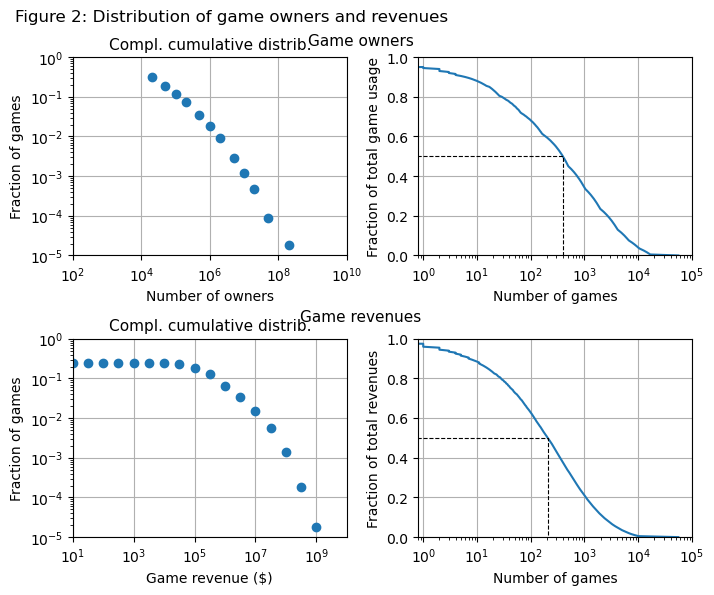

In [23]:
fig2, axs2 = plt.subplots(
    nrows=2, ncols=2, figsize=(7.2, 6), dpi=100,
    gridspec_kw={'left': 0.1, 'right': 0.96, 'top': 0.9, 'bottom': 0.1,
                 'wspace': 0.26, 'hspace': 0.42})
fig2.suptitle('Figure 2: Distribution of game owners and revenues', x=0.02, ha='left')
fig2.text(0.5, 0.92, 'Game owners', ha='center', fontsize=11)
fig2.text(0.5, 0.46, 'Game revenues', ha='center', fontsize=11)


owners_cdf = owners_distrib.toPandas()
axs2[0, 0].plot(owners_cdf.owners_low, owners_cdf.compl_cdf,
                marker='o', linestyle='')
axs2[0, 0].set_xscale('log')
axs2[0, 0].set_xlim(1e2, 1e10)
axs2[0, 0].set_yscale('log')
axs2[0, 0].set_ylim(1e-5, 1)
axs2[0, 0].grid(visible=True)
axs2[0, 0].set_xlabel('Number of owners')
axs2[0, 0].set_ylabel('Fraction of games')
axs2[0, 0].set_title('Compl. cumulative distrib.', fontsize=11)


axs2[0, 1].plot(own_nb_games, 1-own_frac, marker='', linestyle='-')
axs2[0, 1].plot([0, own_nb_games[100], own_nb_games[100]], [0.5, 0.5, 0],
                color='k', lw=0.8, ls='--')
axs2[0, 1].set_xscale('log')
axs2[0, 1].set_xlim(8e-1, 1e5)
axs2[0, 1].set_ylim(0, 1)
axs2[0, 1].grid(visible=True)
axs2[0, 1].set_xlabel('Number of games')
axs2[0, 1].set_ylabel('Fraction of total game usage')


axs2[1, 0].plot(revenues_vals, revenues_cdf, marker='o', linestyle='')
axs2[1, 0].set_xscale('log')
axs2[1, 0].set_xlim(1e1, 1e10)
axs2[1, 0].set_yscale('log')
axs2[1, 0].set_ylim(1e-5, 1)
axs2[1, 0].grid(visible=True)
axs2[1, 0].set_xlabel('Game revenue ($)')
axs2[1, 0].set_ylabel('Fraction of games')
axs2[1, 0].set_title('Compl. cumulative distrib.', fontsize=11)


axs2[1, 1].plot(rev_nb_games, 1-rev_frac, marker='', linestyle='-')
axs2[1, 1].plot([0, rev_nb_games[100], rev_nb_games[100]], [0.5, 0.5, 0],
                color='k', lw=0.8, ls='--')
axs2[1, 1].set_xscale('log')
axs2[1, 1].set_xlim(8e-1, 1e5)
axs2[1, 1].set_ylim(0, 1)
axs2[1, 1].grid(visible=True)
axs2[1, 1].set_xlabel('Number of games')
axs2[1, 1].set_ylabel('Fraction of total revenues')


plt.show()

Figure 2 shows the some characteristics of the distributions of game owners (top) and game revenues (bottom). The left panels show the complementary cumulative distribution functions. A data point represent the fraction of games having larger number of owners/revenues than its abscissa. The first data point at ordinate 1 is not visible. It corresponds to zero abscissa (more than zero owner/zero revenue), and thus does not appear on the log-log plot. The right panels show the fraction of total game units downloaded or game revenues as a function of the number of games, sorted by decreasing importance. These results reveal some important characteristics of the game market:
- The distribution of game owners (and therefore of revenues) is fat tailed. Above a certain threshold, the number of games with a $n$ owners is roughly proportional to $p(n) = \frac{A}{n^{1+\alpha}}$, where the exponent $\alpha$ is an empirical parameter of the distribution. The most important consequence is that a very small fraction of the games concentrates most of the game usage.
- The distribution of revenues shows that only about 25% of the games seem to produce a revenue. This is of course a strong underestimation: we are missing the revenues from microtransactions, advertisement, etc.
- About 400 games (less than 1 %!) account for half the game downloads. This tendency seems even stronger for the revenues with half of the total revenues originating from 200 games (although here we are missing parts of the revenues).

This analysis indicates that the videogames market is actually dominated by a few superproductions.

### Games publishers and developers

We now study how the market is shared among game publishers and developers. We first analyze things in terms of games released. One important metric in the game industry is the number of units sold, which we analyze in second.


#### Number of game releases

In [28]:
publishers_df = spark.sql(
    """
    SELECT 
      publisher,
      COUNT (publisher) AS game_releases,
      SUM (owners_low) AS units_distributed_low 
    FROM 
      main 
    GROUP BY 
      publisher 
    ORDER BY 
      game_releases DESC
    """
)
publishers_df.createOrReplaceTempView('publishers')
publishers_df.show(15)

+--------------------+-------------+---------------------+
|           publisher|game_releases|units_distributed_low|
+--------------------+-------------+---------------------+
|      Big Fish Games|          422|             680000.0|
|              8floor|          202|                  0.0|
|                SEGA|          165|              5.803E7|
|      Strategy First|          151|            4380000.0|
|         Square Enix|          141|                4.8E7|
|     Choice of Games|          140|             110000.0|
|            HH-Games|          132|             100000.0|
|       Sekai Project|          132|            4880000.0|
|                    |          132|            8130000.0|
|             Ubisoft|          127|             1.0252E8|
|        Laush Studio|          126|            1040000.0|
|          THQ Nordic|          125|              2.623E7|
|Alawar Entertainment|          107|             460000.0|
|  Fulqrum Publishing|          104|            8660000.

In [29]:
developers_df = spark.sql(
    """
    SELECT 
      developer, 
      COUNT (developer) AS game_releases,
      SUM (owners_low) AS units_distributed_low 
    FROM 
      main 
    GROUP BY 
      developer
    ORDER BY 
      game_releases DESC
    """
)
developers_df.createOrReplaceTempView('developers')
developers_df.show(15)

+--------------------+-------------+---------------------+
|           developer|game_releases|units_distributed_low|
+--------------------+-------------+---------------------+
|     Choice of Games|          140|             110000.0|
|                    |          127|            7740000.0|
|             Creobit|          122|            3660000.0|
|Laush Dmitriy Ser...|          108|             460000.0|
|   Sokpop Collective|           98|             400000.0|
|KOEI TECMO GAMES ...|           90|            9190000.0|
|      Reforged Group|           89|             430000.0|
|  Boogygames Studios|           80|             310000.0|
|        Hosted Games|           79|             180000.0|
|      Elephant Games|           75|             320000.0|
|       Blender Games|           70|             270000.0|
|              Dnovel|           66|             140000.0|
|                SEGA|           64|            7280000.0|
|         Somer Games|           61|             120000.

There are about 30000 publishers/developers. We recognize some well known companies among top publishers (SEGA, Square Enix). The developer names are less familiar, but we note the presence of individuals (Laush Dmitriy Sergeevich, Artur Smiarowski). These are independent developers, that actually take a large part of the released games. We also note that releasing a large number of games does not imply that a large number of units is distributed.

In [30]:
## Cumulative distributions of number of game releases for developers and publishers
# cannot be done easily with pyspark
vals = np.logspace(0, 3, 13)

pub_releases_cdf = publishers_df.select('game_releases').toPandas().to_numpy()
pub_releases_cdf = np.sum(pub_releases_cdf >= vals, axis=0)

dev_releases_cdf = developers_df.select('game_releases').toPandas().to_numpy()
dev_releases_cdf = np.sum(dev_releases_cdf >= vals, axis=0)

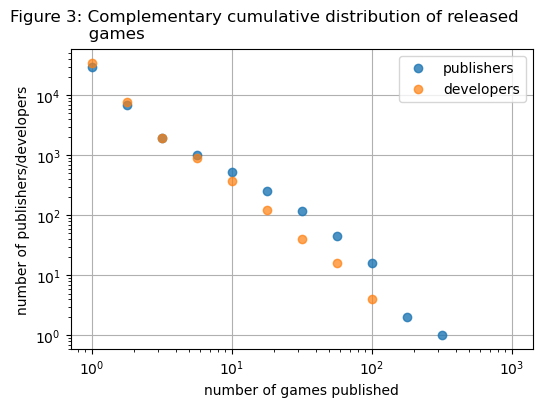

In [ ]:
fig3, ax3 = plt.subplots(
    nrows=1, ncols=1, figsize=(5.5, 4), dpi=100,
    gridspec_kw={'left': 0.13, 'right': 0.97, 'top': 0.88, 'bottom': 0.13})
fig3.suptitle('Figure 3: Complementary cumulative distribution of released'
              '\n               games per publisher/developer',
              x=0.02, ha='left')

ax3.plot(vals, pub_releases_cdf,
         marker='o', linestyle='', alpha=0.8, label='publishers')
ax3.plot(vals, dev_releases_cdf,
         marker='o', linestyle='', alpha=0.7, label='developers')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid(visible=True)
ax3.set_xlabel('number of games published')
ax3.set_ylabel('number of publishers/developers')
ax3.legend()

plt.show()

Figure 3 shows the complementary cumulative distribution of games release by publisher/developer. The interpretation is the same as in figure 2: we represent the number of publshers having more than $x$ games published. Similarly to game usage, we note that the distribution is fat-tailed. Out of the 30000, more than 20000 developers/publishers released only one game. Only a dozen released more than 100 games.

#### Games units distributed

We consider here the total number of games sold by (or downloaded from) a publisher/developer.

In [ ]:
spark.sql("SELECT * FROM publishers ORDER BY units_distributed_low DESC").show(15)

In [ ]:
spark.sql("SELECT * FROM developers ORDER BY units_distributed_low DESC").show(15)

We sort the publishers/developers by number of owners of their games (number of units distributed). The top names are all well known companies. The inhomogeneity in terms of owner base is large, ranging over 7 orders of magnitude. This is a combined effect: the largest companies also attract the largest public.

In [ ]:
## Cumulative distributions of number of game releases for developers and publishers
vals = np.logspace(3, 9, 19)

pub_distribs_cdf = publishers_df.select('units_distributed_low').toPandas().to_numpy()
pub_distribs_cdf = np.sum(pub_distribs_cdf >= vals, axis=0)

dev_distribs_cdf = developers_df.select('units_distributed_low').toPandas().to_numpy()
dev_distribs_cdf = np.sum(dev_distribs_cdf >= vals, axis=0)

In [ ]:
fig4, ax4 = plt.subplots(
    nrows=1, ncols=1, figsize=(5.5, 4), dpi=100,
    gridspec_kw={'left': 0.13, 'right': 0.97, 'top': 0.88, 'bottom': 0.13})
fig4.suptitle('Figure 4: Complementary cumulative distribution of game units'
              '\n               distributed per publisher/developer',
              x=0.02, ha='left')

ax4.plot(vals, pub_distribs_cdf,
         marker='o', linestyle='', alpha=0.8, label='publishers')
ax4.plot(vals, dev_distribs_cdf,
         marker='o', linestyle='', alpha=0.7, label='developpers')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid(visible=True)
ax4.set_xlabel('Total units owned')
ax4.set_ylabel('number of publishers / developers')
ax4.legend()

plt.show()

Figure 4 shows the distribution of owned games by publisher/developer. The position of the first point is approximative due to the large uncertainty in the estination of owners in this case. As expected, we recover a fat-tailed distribution, with a number of units owned that spreads over 7 orders of magnitude. Some companies having "sold" close to 1 billion games in total.


### Evolution of game releases

A company can take more risks in terms of game production in the context of a healthy game market. The situation of the latter is therefore an important for our analysis. In this section, we study it through the evolution of game releases.

A better indication of the market health would be the evolution of the number of players, which is not available in this dataset.

In [ ]:
game_releases_df = spark.sql(
    """
    SELECT 
      *, 
      SUM (nb_releases) OVER (
        ROWS BETWEEN UNBOUNDED PRECEDING 
        AND CURRENT ROW
      ) AS cum_releases 
    FROM 
      (
        SELECT 
          any_value(release_date) - DAY(
            any_value(release_date)
          ) + 1 AS date, 
          COUNT (*) AS nb_releases 
        FROM 
          release_dates 
        WHERE 
          release_date IS NOT NULL 
        GROUP BY 
          YEAR (release_date), 
          MONTH (release_date) 
        ORDER BY 
          YEAR (release_date), 
          MONTH (release_date)
      )
    """
)
game_releases_df.show()

In [ ]:
game_releases = game_releases_df.toPandas().astype({'date': 'datetime64[s]'})


fig5, axs5 = plt.subplots(
    nrows=1, ncols=2, figsize=(7, 3.5), dpi=100,
    gridspec_kw={'left': 0.09, 'right': 0.97, 'top': 0.89, 'bottom': 0.14, 'wspace': 0.24})
fig5.suptitle('Figure 5: Evolution of game releases', x=0.02, ha='left')

axs5[0].plot(game_releases.date, game_releases.nb_releases,
             marker='', linestyle='-')
axs5[0].set_xlim(12410, 19730)
axs5[0].xaxis.set_major_locator(mdates.YearLocator(4))
axs5[0].set_ylim(0, 900)
axs5[0].grid(visible=True)
axs5[0].set_xlabel('Date')
axs5[0].set_ylabel('Monthly game releases')


axs5[1].plot(game_releases.date, game_releases.cum_releases,
             marker='', linestyle='-')
axs5[1].set_xlim(12410, 19730)
axs5[1].xaxis.set_major_locator(mdates.YearLocator(4))
axs5[1].set_ylim(0, 60000)
axs5[1].set_yticks(np.linspace(0, 60000, 7), np.arange(0, 70, 10))
axs5[1].grid(visible=True)
axs5[1].set_xlabel('Date')
axs5[1].set_ylabel('Cumulative game releases (x 1000)')

plt.show()

Figure 5 presents the monthly game releases (left panel) and cumulated releases (right panel). Monthly releases stayed under 50 until 2013, when they increased steadily to 400 in 2017. This is possibly the result of an increase in popularity of Steam's platform, or a change of some sort in policy. For instance it could be the possibility for independent game developers to publish their games on the platform. We then note a jump of about 200 releases in 2017, which stabilizes at 600 during about 3 years. Its cause is unclear. This is followed, in early 2020 by another jump in game releases. This last increase occurs during the global COVID lockdown. The number of releases is stable between 700 and 800 since then.

### General game availability

We conclude this section by analyzing games availability on the platform. This should help getting insights about the target audience for a new game. We focus here on age restrictions and language availabilty.

In [ ]:
restricted_age_games = spark.sql(
    """
    SELECT
      name,
      owners_est
    FROM 
      main
    WHERE 
      required_age > 15
    ORDER BY 
      owners_low DESC
    """
)
restricted_age_games.show()

In [ ]:
restricted_owners_est = restricted_age_games.select('owners_est').groupBy().sum().collect()[0][0]
tot_owners_est = main_df.select('owners_est').groupBy().sum().collect()[0][0]
print("Estimated number of age-restricted games (16+ yo) sold:",
      f"{restricted_owners_est/1e6:.0f} M")
print("Estimated market share of age-restricted games:",
      f"{100 * restricted_owners_est / tot_owners_est:.4} %")

Although most games have no age requirements, some superproductions do have an age limit. Age-restricted games represent an estimated 4.3% of the global market share. Producing an age-restricted game has both advantages and disadvantages. On the one hand, the potential customer basis is mechanically reduced. On the other hand, it allows producers to introduce more features and mechanics in their games.

In [ ]:
## Could not figure a way to do that with SQL
languages_df.toPandas().iloc[:, 2:] \
            .sum() \
            .sort_values(ascending=False) \
            .head(20)

In [ ]:
languages_availability = spark.sql(
    """
    SELECT
      main.name,
      main.owners_est,
      languages.total AS languages_available
    FROM
      main
    INNER JOIN
      languages ON main.appid = languages.appid
    WHERE
      languages.total > 10
    ORDER BY 
      main.owners_est DESC
    """
)
languages_availability.show()

In [ ]:
lang_owners_est = languages_availability.select('owners_est').groupBy().sum().collect()[0][0]
print("Estimated number of games sold available in 10+ languages:",
      f"{lang_owners_est/1e6:.0f} M")
print("Estimated market share of games available in 10+ languages:",
      f"{100 * lang_owners_est /tot_owners_est:.4} %")

Almost all games are available in english. There is a large gap in language availability between english and other languages. Only about 20% of them are also available in other european languages (french, german, italian, etc). However, those games that attract many players also are available in many languages. About 40% of games downloaded are available in more than 10 languages.

It is important to note that language availability does not necessarily means translation of in-game voices, the availability may be limited to menu translation and subtitles.

## <a name="genres"></a> Genres analysis

Some game genres are more popular than others, or more expensive to develop. Some developers/publishers have more expertise in some specific genres. The choice of the genre for a game release must take these factors into account. We now analyze the market from the games genres perspective.

In [ ]:
genres_df.toPandas().iloc[:, 1:].sum().sort_values(ascending=False)

Most games are from independent developers/publishers (`'Indie'` genre). This is expected since those games are in general faster to produce, and their development is acessible to many people. THe most proeminent genres are the action-adventure games. Casual games, aiming at a broad public rather than the hobbyist player, are also proeminent. This is explained by the fact those, like independent games, are smaller and thus faster to produce. It is also important to note that a game can have multiple genres: `'Action'` and `'Adventure'` often go together, and `'Indie'` is not a genre *per se*.

In [ ]:
## average grade for each genre
# prepare the dataframe with SQL
genres_grades_df = spark.sql(
    """
    SELECT
      genres.*,
      main.positive / SQRT(main.positive + main.negative) AS weighted_grade,
      SQRT(main.positive + main.negative) AS weight
    FROM
      main
    JOIN
      genres ON main.appid = genres.appid
    """
)

In [ ]:
## data processing must be done with Pandas
genres_grades_df = genres_grades_df.toPandas()
genre_grades = {}
for genre in genres_grades_df.columns[1:-2]:
    df_ = genres_grades_df.loc[genres_grades_df[genre] == 1, ['weighted_grade', 'weight']]
    genre_grades[genre] = df_['weighted_grade'].sum() / df_['weight'].sum()

grades_df = pd.Series(genre_grades, name='grade')
grades_df.sort_values(ascending=False)

We compute the genres grades by averaging the number of positive reviews, weighted with the number of reviews for each game. All genres receive generally positive reviews.

In [ ]:
def genres_by_publishers(publishers: list[str])-> pd.DataFrame:
    """
    Numbers of games released in each genre category for the given publishers.
    """
    where = '\n OR '.join(f"main.publisher == '{pub}'" for pub in publishers)
    df_ = spark.sql(
        f"""
        SELECT
          genres.*,
          main.publisher
        FROM
          genres
        JOIN
          main on genres.appid = main.appid
        WHERE
          {where}
        """
    )
    # genres get an ugly name when aggregating in pyspark
    df_ = df_.drop('appid').toPandas()
    return df_.groupby('publisher').sum().T


def genres_by_developers(developers: list[str])-> pd.DataFrame:
    """
    Numbers of games released in each genre category for the given developers.
    """
    where = '\n OR '.join(f"main.developer == '{pub}'" for pub in developers)
    df_ = spark.sql(
        f"""
        SELECT
          genres.*,
          main.developer
        FROM
          genres
        JOIN
          main on genres.appid = main.appid
        WHERE
          {where}
        """
    )
    # genres get an ugly name when aggregating in pyspark
    df_ = df_.drop('appid').toPandas()
    return df_.groupby('developer').sum().T

In [ ]:
genres_by_publishers(['Valve', 'Ubisoft'])

In [ ]:
genres_by_developers(['CAPCOM Co., Ltd.', 'Bethesda Game Studios'])

We can see that some publishers are specialized in some genres. For instance, Valve published almost exclusively action games. Ubisoft, on the other hand, is more diversified. Developers also specialize in some game genres. Bethesda produces mainly RPGs, while Capcom delelops action-adventure games.

In [ ]:
## estimated number of units distributed for each genre
genres_owners_df = spark.sql(
    """
    SELECT
      genres.*,
      main.owners_est AS owners_est
    FROM
      main
    JOIN
      genres ON main.appid = genres.appid
    """
)

In [ ]:
## data processing must be done with Pandas
genres_owners_df = genres_owners_df.toPandas()
genre_owners = {}
for genre in genres_owners_df.columns[1:-1]:
    df_ = genres_owners_df.loc[genres_owners_df[genre] == 1, ['owners_est']]
    genre_owners[genre] = df_['owners_est'].sum()

owners_df = pd.Series(genre_owners, name='grade')
owners_df.sort_values(ascending=False)

Action and adventure are the most popular genres. Independent games also take a significant market share.

In [ ]:
## Evolution of game releases by genre
genre_releases_df = release_dates_df.join(genres_df, 'appid') \
    .where(F.col('release_date').isNotNull()) \
    .select(F.trunc('release_date', 'month').alias('date'),
            *[F.col(c) for c in genres_df.columns if c != 'appid']) \
    .groupBy('date').sum() \
    .sort('date', ascending=True) \
    .toDF('date', *[c for c in genres_df.columns if c != 'appid'])

genre_releases_df

In [ ]:
## Cumulative monthly releases
cumsum_window = Window.rowsBetween(Window.unboundedPreceding, Window.currentRow)
genre_releases_cumsum_df = genre_releases_df.select(
    'date',
    *[F.sum(c).over(cumsum_window).alias(c)
      for c in genre_releases_df.columns if c != 'date'])

genre_releases_df = genre_releases_df.toPandas().astype({'date': 'datetime64[s]'})
genre_releases_cumsum_df = genre_releases_cumsum_df.toPandas().astype({'date': 'datetime64[s]'})

genre_releases_cumsum_df

In [ ]:
COLORS = [
    '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000',
    '#95d0fc', '#029386', '#f97306', '#96f97b', '#c20078', '#ffff14',
    '#75bbfd', '#0cff0c', '#bf77f6', '#9a0eea', '#033500', '#06c2ac',
    '#c79fef', '#00035b', '#d1b26f', '#00ffff', '#06470c', '#929591',
    ]

fig6, axs6 = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 5), dpi=100,
    gridspec_kw={'left': 0.08, 'right': 0.97, 'top': 0.59, 'bottom': 0.1, 'wspace': 0.25})
fig6.suptitle('Figure 6: Evolution of game genre releases', x=0.02, ha='left')

polys = axs6[0].stackplot(
    genre_releases_df['date'], genre_releases_df.iloc[:, 1:].T,
    colors=COLORS)
axs6[0].set_xlim(12410, 19730)
axs6[0].xaxis.set_major_locator(mdates.YearLocator(4))
axs6[0].set_ylim(0, 2500)
axs6[0].set_yticks(np.linspace(0, 2500, 6), np.linspace(0, 2.5, 6))
axs6[0].grid(visible=True)
axs6[0].set_xlabel('Date')
axs6[0].set_ylabel('Monthly releases (x 1000)')


axs6[1].stackplot(
    genre_releases_cumsum_df['date'], genre_releases_cumsum_df.iloc[:, 1:].T,
    baseline='zero', colors=COLORS)
axs6[1].set_xlim(12410, 19730)
axs6[1].xaxis.set_major_locator(mdates.YearLocator(4))
axs6[1].set_ylim(0, 160000)
axs6[1].set_yticks(np.linspace(0, 160000, 9), np.arange(0, 180, 20))
axs6[1].grid(visible=True)
axs6[1].set_xlabel('Date')
axs6[1].set_ylabel('Cumulative releases (x 1000)')

fig6.legend(handles=polys, labels=genre_releases_df.columns[1:].to_list(),
            ncols=4, loc=(0.06, 0.62), fontsize=9)

plt.show()

Figure 7 shows stack plots of monthly genre releases (left panel) and cumulated releases (right panel) over time. The counts are larger than the number of games since the latter can have multiple genres. The incresaing trend in game releases appear to be balanced between all the major genres. No genre is gaining interest over time.

## <a name="platform"></a> Platform analysis

The choice of platform availability is important in game production. Being available in different platforms brings more public, but this may not be worth the extra costs (eg licences and software adaptation). We therefore conclude our study of the game market by focusing on the importance of the different platform available: Windows, Mac and Linux.

In [ ]:
## number of games available on each platform
platforms_df.toPandas().iloc[:, 1:].sum().sort_values(ascending=False)

In [ ]:
## fraction of games available on each platform
platforms_df.toPandas().iloc[:, 1:].mean().sort_values(ascending=False)

Almost all games are available on Windows, while only 23% and 15% of the games are available on Mac and linux, respectively. This makes Windows a mandatory platform for computer games.

In [ ]:
## platform availability in terms of games owners
## Using pyspark/SQL for this computation is affordable due to the limited number of platforms
owner_platform_availability = {}
tot_owners = main_df.select(F.sum('owners_est')).collect()[0][0]
for platform in platforms_df.columns[1:]:
    df_ = spark.sql(
        f"""
        SELECT
          SUM(main.owners_est) AS {platform}
        FROM
          main
        JOIN
          platforms ON main.appid = platforms.appid
        WHERE
          platforms.{platform} IS TRUE
        """
    )
    owner_platform_availability[platform] = [df_.collect()[0][0]/tot_owners]
pd.DataFrame(owner_platform_availability, index=['availability'])

Although only 15/23% of the games are available to Linux and Mac users, the availability rises to 33/41% in terms of downloaded games. This means that popular games tend to be available on Mac and Linux.

In [ ]:
## platform availability in terms of game genres
genre_names = genres_df.columns[1:]
tot_genres = np.array(genres_df.select(*[F.sum(c) for c in genres_df.columns if c != 'appid']).collect()[0])
genre_platform_availability = {}
for platform in platforms_df.columns[1:]:
    df_ = genres_df.join(platforms_df, 'appid') \
                   .where(F.col(platform) == True) \
                   .select(*[F.sum(c) for c in genres_df.columns if c != 'appid'])
    genre_platform_availability[platform] = list(df_.collect()[0])

genre_availability_df = pd.DataFrame(genre_platform_availability, index=genre_names)
genre_availability_df = genre_availability_df.iloc[np.argsort(tot_genres)[::-1], :]
genre_availability_df

In [ ]:
genre_availability_df.div(np.sort(tot_genres)[::-1], axis=0)

Independent and strategy games have a larger availability on Mac and Linux platforms than average.

In [ ]:
## Monthly game releases
## Here we can select the column 'linux', 'mac', 'windows' manually
platform_releases_df = spark.sql(
    """
    SELECT
      TRUNC(d.release_date, "month") as date,
      SUM (CAST(platforms.linux AS INTEGER)) AS linux,
      SUM (CAST(platforms.mac AS INTEGER)) AS mac,
      SUM (CAST(platforms.windows AS INTEGER)) AS windows,
      SUM (SUM (CAST(platforms.linux AS INTEGER))) OVER (
        ORDER BY 
          TRUNC(d.release_date, "month") ROWS BETWEEN UNBOUNDED PRECEDING 
        AND CURRENT ROW
      ) AS cum_linux,
      SUM (SUM (CAST(platforms.mac AS INTEGER))) OVER (
        ORDER BY 
          TRUNC(d.release_date, "month") ROWS BETWEEN UNBOUNDED PRECEDING 
        AND CURRENT ROW
      ) AS cum_mac,
      SUM (SUM (CAST(platforms.windows AS INTEGER))) OVER (
        ORDER BY 
          TRUNC(d.release_date, "month") ROWS BETWEEN UNBOUNDED PRECEDING 
        AND CURRENT ROW
      ) AS cum_windows
    FROM
      d.release_dates AS d
    JOIN
      platforms ON d.release_dates.appid = platforms.appid
    WHERE
      d.release_date IS NOT NULL
    GROUP BY
      TRUNC(d.release_date, "month")
    ORDER BY
      TRUNC(d.release_date, "month")
    """
)
platform_releases_df.show()

In [ ]:
platform_monthly_releases = platform_releases_df \
    .select('date', 'linux', 'mac', 'windows') \
    .toPandas().astype({'date': 'datetime64[s]'}) \
    .set_index('date')
cum_platform_monthly_releases = platform_releases_df \
    .select('date', 'cum_linux', 'cum_mac', 'cum_windows') \
    .toPandas().astype({'date': 'datetime64[s]'}) \
    .set_index('date')

In [ ]:
fig7, axs7 = plt.subplots(
    nrows=1, ncols=2, figsize=(7, 3.8), dpi=100,
    gridspec_kw={'left': 0.1, 'right': 0.97, 'top': 0.83, 'bottom': 0.13, 'wspace': 0.25})
fig7.suptitle('Figure 7: Evolution of game releases in different platforms', x=0.02, ha='left')

polys = axs7[0].stackplot(platform_monthly_releases.index, platform_monthly_releases.T)
axs7[0].set_xlim(12410, 19730)
axs7[0].xaxis.set_major_locator(mdates.YearLocator(4))
axs7[0].set_ylim(0, 1200)
axs7[0].set_yticks(np.linspace(0, 1200, 7))
axs7[0].grid(visible=True)
axs7[0].set_xlabel('Date')
axs7[0].set_ylabel('Monthly game releases (x 1000)')

axs7[1].stackplot(cum_platform_monthly_releases.index, cum_platform_monthly_releases.T)
axs7[1].set_xlim(12410, 19730)
axs7[1].xaxis.set_major_locator(mdates.YearLocator(4))
axs7[1].set_ylim(0, 80000)
axs7[1].set_yticks(np.linspace(0, 80000, 9), np.arange(0, 90, 10))
axs7[1].grid(visible=True)
axs7[1].set_xlabel('Date')
axs7[1].set_ylabel('Cumulative game releases (x 1000)')

fig7.legend(handles=polys, labels=platform_monthly_releases.columns.to_list(),
            ncols=3, loc=(0.3, 0.86))

plt.show()

Figure 7 shows stack plots of monthly game releases over time (left panel) and their cumulated number (right panel). The trend is stable over time. The different pLatforms availability does not change significantly over time. No platform seems to be taking over the others.

## <a name="conclusion"></a> Conclusion and perspectives

We can summarize the results of our study of Steam's game marketplace with the following points:
- In terms of shares, the market is dominated by a few superproductions from major publisher companies.
These games are played by many players and generate the largest revenues. This market structure is actually
quite general and occurs accross the whole entertainment inductry (music, movies, series, etc).
- About half publishers/developers released only one game. These are independent people or very small companies.
Similarly to the revenues, the game release-by-company distribution is fat tailed,
with only about 10 companies having released more than 100 games. 
- This structure translates to the distribution of the company's customer base. The amplitude of variation here is even larger,
considering that games released by large comanies also have more players.
- The game releases seem stable since early 2020 with about 700-800 monthly releases.
- The genre and platform availability of released games is stable over time


In terms of strategy for a new videogame from an important company such as Ubisoft, we can provide the following advices:
- The company has enough ressources to make a superproduction, which is definitely an option to consider.
However, the associated production costs are also large and so are the financial risks.
- For a video game with a completely new gameplay or concept, the risks might be unacceptable. For
such a game, one could consider being less ambitious and test the concept on a smaller scale, for instance by
publishing a game with limited production costs.
- In terms of genres, one should focus on the main genres: action adventure, strategy, RPG, etc. and choose from
those in which the company has expertise.
- For a large production, translating the game is a necessity. Adapting the game to many platforms is also
strategic since the associated costs are low as compared to the other production costs.
The gains in players likely outweights the adaptation costs.


Our analysis has some limitations, some of which we mentioned in the introduction. We recall the most important ones:
- We have very limited information on the actual game usage. The number of game owners is provided as a rather braod range
which forced us to construct a very rough estimate. We do not now whether people actually play to the game, nor how
many time they spend playing.
- The number of game owners corresponds to the values at the time when the datset was built. We have no information
about its evolution in time, which would be useful to make prospects.
- Our data are limited to computer platforms. it would be very beneficial to a market analysis to include video games usage in phones or consoles.
- Even in the scope of computer platforms, we are only considering Steam's marketplace.
We miss information for video games not directly available on Steam (for instance, Fortnite, one on the most played games).